The idea here is to finally parse/plot coordinates of the infleCS analysis onto meaningful coordinates, as these are the most representative snapshots of the simulations and the paths they take.

A lot of this script is adapted from `per_iteration_analysis` or `per_bead_analysis` but since here we are mostly comparing conditions, it's pared down to only that

# Table of contents:
- EC vs IC gate
- RMSD to original structure/ atom sim
- Protein contact analysis:
    - Salt bridge contacts
    - Lysine on TM1
    - ICH movements
    - Contacts to Darko CVs
- TM7b kink & TM10 kink
- Protein hydration
- Sugar coordination:
    - Contacts to sugar molecules
    - Sugar binding site differences in apo vs BFRU


# imports and data processing

In [114]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
import gate_functions
import MDAnalysis.analysis.distances as d
from math import ceil

In [5]:
indir = f'/data2/GLUT5_string/string/analysis/scripts/infleCS/InfleCS-free-energy-clustering-tutorial-master/paths_clustercenters/confouts_xtcs'

condition = 'influx_BFRU_gate_CV'
pathway_BFRU = mda.Universe(f'../confout_files/tpr_files/{condition}.wholesys.tpr', f"{indir}/{condition}/inflecs_path.xtc")
clustercenters_BFRU = mda.Universe(f'../confout_files/tpr_files/{condition}.wholesys.tpr', f"{indir}/{condition}/inflecs_clusters_all.pdb")

condition = 'influx_apo_gate_CV'
pathway_apo = mda.Universe(f'../confout_files/tpr_files/{condition}.wholesys.tpr', f"{indir}/{condition}/inflecs_path.xtc")
clustercenters_apo = mda.Universe(f'../confout_files/tpr_files/{condition}.wholesys.tpr', f"{indir}/{condition}/inflecs_clusters_all.pdb")

# The usual: compare IC and EC

In [57]:
condition = 'influx_apo_gate_CV'
gmx_ic = np.loadtxt(f"{indir}/{condition}/pathway.IC_gate.xvg")[:,1]
gmx_ec = np.loadtxt(f"{indir}/{condition}/pathway.EC_gate.xvg")[:,1]

## because we use tpr file, we have to remove 1 value from res numbers!! 
mda_ec_A_path, mda_ic_A_path = gate_functions.make_gate_arr(md_uni=pathway_apo, 
                                              gate_EC = [(29,36), (288,294)], 
                                              gate_IC = [(135,144), (385,393)]
)

mda_ec_B_path, mda_ic_B_path = gate_functions.make_gate_arr(md_uni=pathway_BFRU, 
                                              gate_EC = [(29,36), (288,294)], 
                                              gate_IC = [(135,144), (385,393)]
)

mda_ec_A_clu, mda_ic_A_clu = gate_functions.make_gate_arr(md_uni=clustercenters_apo, 
                                              gate_EC = [(29,36), (288,294)], 
                                              gate_IC = [(135,144), (385,393)]
)

mda_ec_B_clu, mda_ic_B_clu = gate_functions.make_gate_arr(md_uni=clustercenters_BFRU, 
                                              gate_EC = [(29,36), (288,294)], 
                                              gate_IC = [(135,144), (385,393)]
)

returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists


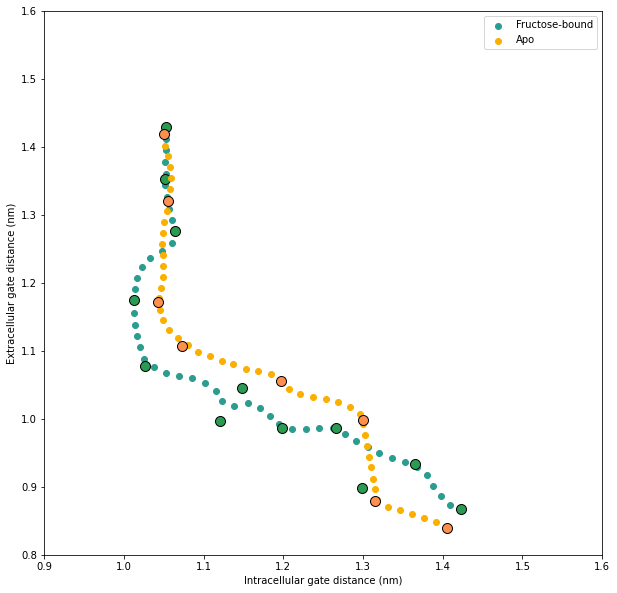

In [69]:
f = plt.figure(figsize = (10,10))

plt.scatter((mda_ic_B_path/10), (mda_ec_B_path/10), label = 'Fructose-bound', color = '#2A9D8F')
plt.scatter((mda_ic_B_clu/10), (mda_ec_B_clu/10), color = '#2A9B52', s = 100, edgecolor = 'black')

plt.scatter((mda_ic_A_path/10), (mda_ec_A_path/10), label = 'Apo', color = '#FBAF00')
plt.scatter((mda_ic_A_clu/10), (mda_ec_A_clu/10), color = '#FF8F4E', s = 100, edgecolor = 'black')


plt.xlim(0.9,1.6)
plt.ylim(0.8,1.6)

plt.xlabel("Intracellular gate distance (nm)")
plt.ylabel("Extracellular gate distance (nm)")

plt.legend()

# Protein contact analysis
## Salt bridge contacts ie sugar porter motif


In paper: E151/E145(TM4) contacts R97/R91(TM3) and R407/R401(TM11). E400/E394(TM10) contacts R158/R152(TM5) and R340/R334(TM9). In IF conf: inter-TM bundles (E400-R158 & E151-R407) are apart (7A and 13A). E336/E330(TM8) is an extra salt bridge res that is not part of SP motif, but it contacts R340 during OF, but not IF

In [32]:
## todo - check to be extra sure that contact you are getting in MDA is same as contact in gmx

salt_bridges = [('GLU:145', 'ARG:91'), ('GLU:145', 'ARG:401'), \
                ('GLU:394', 'ARG:152'), ('GLU:394', 'ARG:334'), \
                ('GLU:330', 'ARG:334')]

In [106]:
def get_salt_bridge(md_uni, salt_bridge_list, paper_num = None):
    print ('removing one from each resid, as tpr file being used')
    bridges_all = np.zeros((len(salt_bridge_list), len(md_uni.trajectory)))
    labels = []
    for n, SB in enumerate(salt_bridge_list):
        c1 = md_uni.select_atoms(f"resname {SB[0].split(':')[0]} and resid {int(SB[0].split(':')[1]) - 1}")
        c2 = md_uni.select_atoms(f"resname {SB[1].split(':')[0]} and resid {int(SB[1].split(':')[1]) - 1}")
    
        sb_dists = []
        for ts in md_uni.trajectory:
            sb_dists.append(np.min(d.distance_array(c1.positions, c2.positions)))
        
        bridges_all[n] = sb_dists
        if not paper_num:
            labels.append(f'{SB[0]} - {SB[1]}')
        else:
            print('Returning label as paper numbering (+6)')
            labels.append(f"{SB[0].split(':')[0]}:{int(SB[0].split(':')[1]) + 6} - {SB[1].split(':')[0]}:{int(SB[1].split(':')[1]) + 6}")
    return bridges_all, labels

In [155]:
apo_br_path, labels = get_salt_bridge(pathway_apo, salt_bridges, paper_num = True)
bfru_br_path, labels = get_salt_bridge(pathway_BFRU, salt_bridges, paper_num = True)

removing one from each resid, as tpr file being used


/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/core/selection.py:675: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(vals), dtype=np.bool)


Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
removing one from each resid, as tpr file being used
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)


Here, we can compare conditions (BFRU vs apo) to see how each salt bridge is holding up

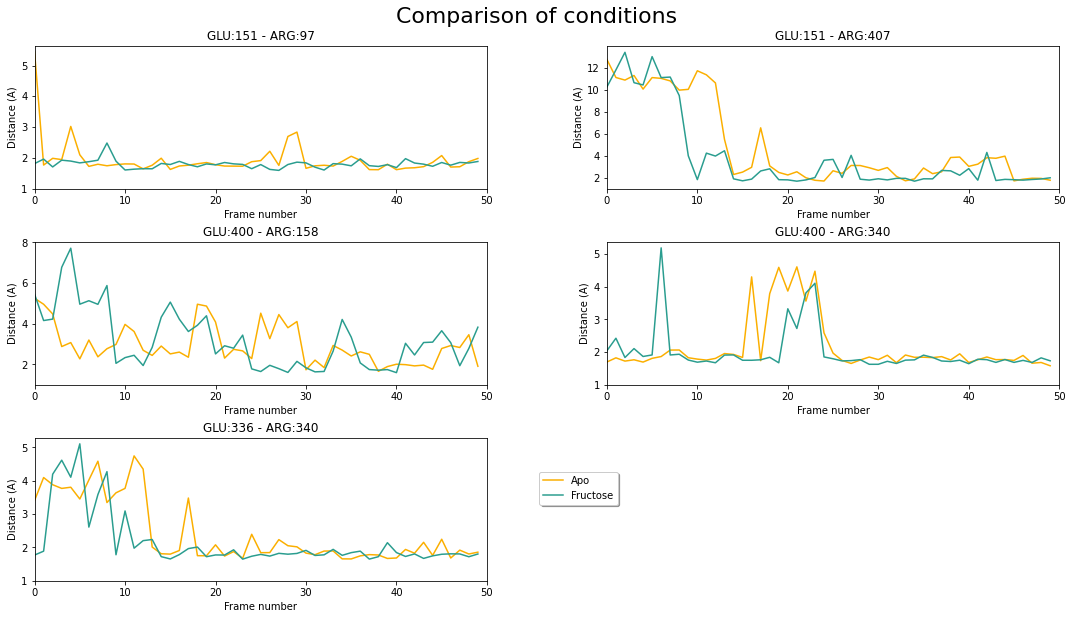

In [156]:
num_cols = 2
fig, ax = plt.subplots(ceil(len(labels) / num_cols), num_cols, figsize=(15, 3 * ceil(len(labels) / 2)))
ax = ax.flatten()

if len(labels) % num_cols:
    fig.delaxes(ax[-1])   
    ax = ax[:-1]
    
for n in range(len(labels)):
    ax[n].plot(apo_br_path[n], color = '#FBAF00', label = 'Apo')
    ax[n].plot(bfru_br_path[n], color = '#2A9D8F', label = 'Fructose')
    ax[n].set_xlim(0, len(pathway_apo.trajectory))
    ax[n].set_ylim(1, )
    
    ax[n].set_xlabel("Frame number")
    ax[n].set_ylabel("Distance (A)")
    ax[n].set_title(labels[n])
    
ax[n].legend(loc = 'upper right', bbox_to_anchor = (1.3, 0.8), shadow = True)
plt.tight_layout()

st = fig.suptitle("Comparison of conditions", fontsize=22)
st.set_y(0.95)
fig.subplots_adjust(top=0.89)

It is however, mostly useful to look at the whole bridge coordination at once. Here I think it's easier to just choose one condition and plot that rather than having multiple conditions on a graph. Just have to change which md uni to read in

For now, we just have 2 bridges (see GLUT5 paper). You may want to toggle on or off the E336-R340 contact

In [157]:
bridge1, labels_b1 = get_salt_bridge(pathway_apo,
                    salt_bridge_list= [('GLU:145', 'ARG:91'), ('GLU:145', 'ARG:401')])

bridge2, labels_b2 = get_salt_bridge(pathway_apo, 
                    salt_bridge_list=[('GLU:394', 'ARG:152'), ('GLU:394', 'ARG:334'),('GLU:330', 'ARG:334')])

removing one from each resid, as tpr file being used


/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/core/selection.py:675: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(vals), dtype=np.bool)


removing one from each resid, as tpr file being used


(1.0, 6.0)

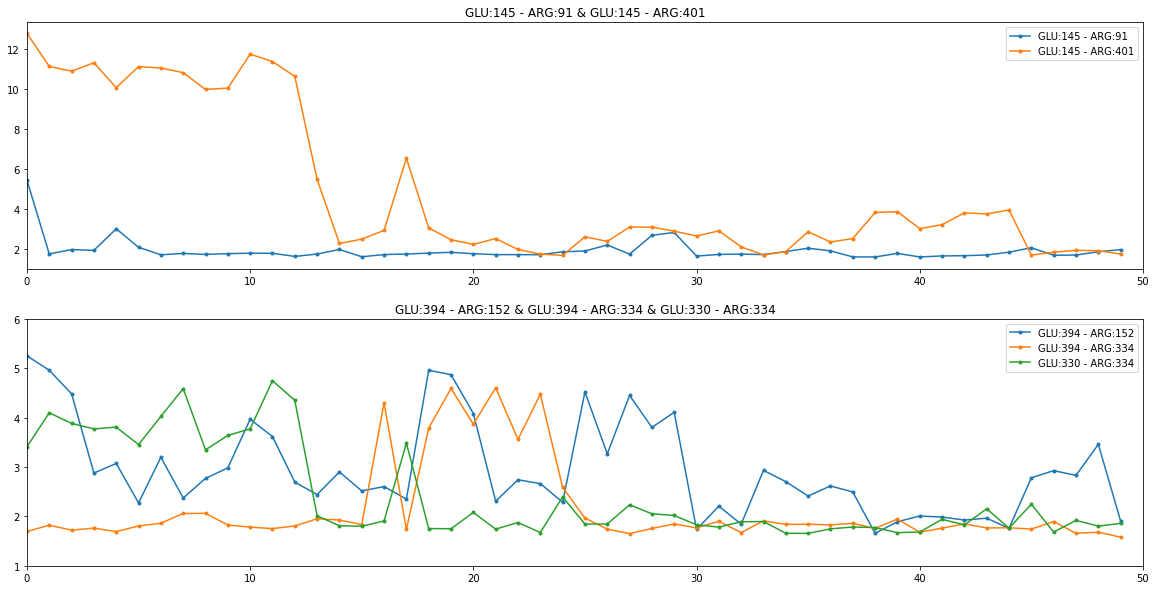

In [180]:
f, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (20,10))


for n in range(len(bridge1)):
    ax1.plot(bridge1[n], label = labels_b1[n], marker = '.', )
    ax1.set_title(' & '.join(labels_b1))

ax1.legend()
ax1.set_xlim(0, 50)
ax1.set_ylim(1,)


for n in range(len(bridge2)):
    ax2.plot(bridge2[n], label = labels_b2[n], marker='.')
    ax2.set_title(' & '.join(labels_b2))

ax2.legend()
ax2.set_xlim(0, 50)
ax2.set_ylim(1,6)

'GLU:145 - ARG:91 & GLU:145 - ARG:401'

## ICH movements 
ICH5 movement, is it stable? ICH1-3 contacts to R407(TM11)

# TM7B kink


All we need to do here is define 2 vectors that make this TM7b, and then calculate the angle they make.

Here's a visualization of this:
<div>
<img src="TM7b_angle.png" width="300"/>
</div>


Where blue is most inward open, green is out open.

The dots are CA of G285, Y291, and A300 (bottom to top)

We would expect that the green should end up a bit less than 180 degrees, while blue is maybe 90-ish

In [316]:
from MDAnalysis.core.topologyobjects import Angle
from numpy.linalg import norm

In [317]:
def get_theta(u):
    A = u.select_atoms("resid 284 and resname GLY and name CA").center_of_geometry()
    B = u.select_atoms("resid 290 and resname TYR and name CA").center_of_geometry()
    C = u.select_atoms("resid 299 and resname ALA and name CA").center_of_geometry()

    BA = A - B
    BC = C - B

    theta = np.arccos(np.dot(BA,BC)/(norm(BA)*norm(BC)))
    print(np.rad2deg(theta))

In [320]:
A = clustercenters_apo.select_atoms("resid 284 and resname GLY and name CA")
B = clustercenters_apo.select_atoms("resid 290 and resname TYR and name CA")
C = clustercenters_apo.select_atoms("resid 299 and resname ALA and name CA")

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/core/selection.py:675: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(vals), dtype=np.bool)


In [321]:
ix = [A.indices[0], B.indices[0], C.indices[0]]
ix = np.array(ix)

In [322]:
for ts in clustercenters_apo.trajectory:
    an = Angle(ix, clustercenters_apo)
    print(an.angle())

101.47740294760325
81.81568569460997
104.7930114248897
107.10235339429755
104.79069951812374
103.01344738137264
102.18587107354557
98.99031806120762
